### Will a Customer Accept the Coffee Coupon?


**Introduction**

This project seeks to determine what properties, such as time of day or age, are associated with a higher likelihood of accepting coffee coupons

#### Brief Summary of Results

Some of the categories that tended to be associated with a greater likelihood of accepting coffee coupons were:

- mid-high frequency of visiting coffee locations
- being within 15-25 minutes of the coupon location
- sunny weather/temperature in the 80's
- having no urgent destination
- having friends as passengers
- having a 1-day expiration window (vs. a 2-hour window)

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \\$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\\$20 - \\$50). 

### Import Statements

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import chain, combinations

### Quick look at the coupons data

Reading in the `coupons.csv` file:

In [38]:
data = pd.read_csv('coupons.csv')

In [39]:
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

### Removal of observations with missing values

I decided to drop the 'car' column because there are so few non-missing values,
and will be difficult to get a result with this variable that meaningfully differentiates coupon acceptance
rates:

In [41]:
data_drop_car = data.drop('car', axis=1)

### Comparing acceptance rates between groups

I will eventually drop the other 605 rows that have missing data, which is just shy of 5% of the total number of observations, but first I want to compare the coupon acceptance
rate between the data that have missing values and those that do not:

In [42]:
nan_data = data_drop_car[data_drop_car.isnull().values.any(axis=1)]
nan_data['Y'].value_counts(normalize=True)

1    0.550413
0    0.449587
Name: Y, dtype: float64

In [43]:
data_drop = data_drop_car.dropna()
data_drop['Y'].value_counts(normalize=True)

1    0.569335
0    0.430665
Name: Y, dtype: float64

The difference in coupon acceptance rates between the two groups is relatively small (~<2%), so although the observations removed are relatively few, it's nice to know the two groups aren't too dissimilar in this regard. 

After dropping the observations with missing values, approximiately 57% of the observations chose to accept coupons of all types

### Preliminary Visualizations

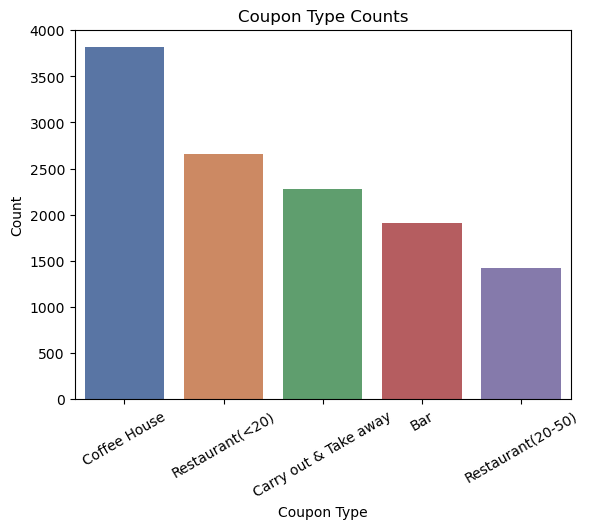

In [44]:
coupon_types = data_drop['coupon'].value_counts().index
palette = np.array(sns.color_palette("deep"))[:len(coupon_types)]

# To preserve coupon-color consistency between plots
palette_dict = dict(zip(coupon_types, palette)) 

coupon_counts = data_drop['coupon'].value_counts().values
sns.barplot(x=coupon_types, y=coupon_counts, palette=palette)
plt.xticks(rotation=30)
plt.title("Coupon Type Counts")
plt.ylabel('Count')
plt.xlabel('Coupon Type')
plt.show()

Coffee coupons were the largest share of coupons distributed, almost a third of all coupons

Next I wanted to visually compare the coupon acceptance rates between coupon types for context:

In [45]:
coupon_acceptance_rate = data_drop.groupby('coupon')['Y'].value_counts(normalize=True).unstack().reset_index()
coupon_acceptance_rate = coupon_acceptance_rate[['coupon',1]].rename({1:"acceptance_rate"}, axis=1)
coupon_acceptance_rate_sorted = coupon_acceptance_rate.sort_values(by='acceptance_rate', ascending=False).reset_index(drop=True)

In [46]:
# establish the sorting order of coupon types to preserve the associated colors between barplots
col_order = coupon_acceptance_rate_sorted['coupon'].tolist()
palette_order = [palette_dict[col] for col in col_order]

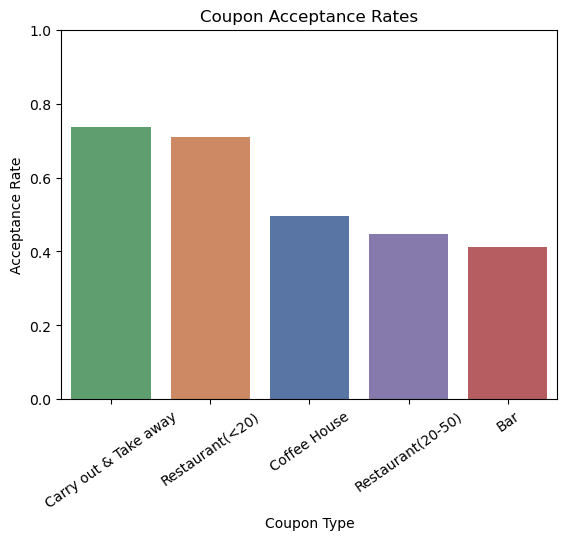

In [47]:
sns.barplot(coupon_acceptance_rate_sorted, x='coupon', y='acceptance_rate', errorbar=None, palette=palette_order)
plt.xticks(rotation=35)
plt.ylim(0,1.0)
plt.title("Coupon Acceptance Rates")
plt.ylabel('Acceptance Rate')
plt.xlabel('Coupon Type')
plt.show()

Coffee coupons had one of the lower acceptance rates (just under 50%)  

### Data mapping

Before I filter the data to focus on coffee coupons, I wanted to modify the data and turn some the categorical variables to numeric data for easier analysis:

In [48]:
time_mapper = {"6PM":18,"7AM":7, "10AM":10, "2PM":14, "10PM":22}

income_mapper = {'$62500 - $74999':62500,
 '$12500 - $24999':12500,
 '$75000 - $87499':75000,
 '$50000 - $62499':50000,
 '$37500 - $49999':37500,
 '$25000 - $37499':25000,
 '$100000 or More':100000,
 '$87500 - $99999':87500,
 'Less than $12500':6250}

age_mapper = {'21':21,
              '46':46,
              '26':26, 
              '31':31, 
              '41':41, 
              '50plus':50, 
              '36':36, 
              'below21':18}

In [49]:
# To avoid SettingwithCopyWarning (everything works as intended):
pd.options.mode.chained_assignment = None
data_drop.loc[:,"time_numeric"] = data_drop['time'].map(time_mapper)
data_drop.loc[:,'income_min_numeric'] = data_drop['income'].map(income_mapper)
data_drop.loc[:,'age_numeric'] = data_drop['age'].map(age_mapper)
data_drop.rename(columns={'passanger':"passenger"},inplace=True)
# To avoid missing possible future true positives of the SettingwithCopyWarning:
pd.options.mode.chained_assignment = 'warn'

In [50]:
chosen_columns = ['destination', 'passenger', 'weather', 'temperature', 'time_numeric', 'coupon',
       'expiration', 'gender', 'age_numeric', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income_min_numeric', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y']

data_select = data_drop[chosen_columns]

## Investigating Coffee House Coupon Recipients

Coffee coupons were distributed in the largest number but had one of the lower rates of acceptance (just under 50%), which is also lower than the overall coupon acceptance rate of 57%, so the rest of this exploration will focus on coffee coupon data.

In [51]:
coffee_coupons = data_select.query('coupon == "Coffee House"')

### Acceptance rates split into various groups of two variables

Here we will calculate and sort the acceptance rates for groups split up by the values of two variables.

It also includes the number of observations for each group in the 'total_count' column, so you can calculate the number of coupons declined in each group by calculating: (1-acceptance_rate) * total_count

In [52]:
def create_sorted_2_var_rate(df, var_1, var_2, threshold=30):
    data = df.groupby([var_1,var_2])['Y'].value_counts().unstack().reset_index()
    data['total_count'] = data[1] + data[0]
    data['acceptance_rate'] = data[1] / data['total_count']
    data = data[[var_1,var_2, 'acceptance_rate', 'total_count']]
    sorted_data = data.sort_values('acceptance_rate', ascending=False).reset_index(drop=True)
    return sorted_data.query('total_count >= @threshold')

In [53]:
create_sorted_2_var_rate(coffee_coupons,'education', 'CoffeeHouse', 30).head(5)

Y,education,CoffeeHouse,acceptance_rate,total_count
1,High School Graduate,1~3,0.852459,61
2,Some college - no degree,gt8,0.752381,105
4,Some college - no degree,4~8,0.705036,139
5,Bachelors degree,4~8,0.693122,189
6,Bachelors degree,gt8,0.677778,90


In [54]:
create_sorted_2_var_rate(coffee_coupons,'education', 'CoffeeHouse', 30).tail(5)

Y,education,CoffeeHouse,acceptance_rate,total_count
22,High School Graduate,never,0.293478,92
23,Graduate degree (Masters or Doctorate),never,0.216495,97
24,Some college - no degree,never,0.162712,295
25,Bachelors degree,never,0.139394,330
26,Associates degree,never,0.138889,72


From this we can see, just looking at education level and how frequently each person went to a coffee place, with a minimum of 30 observations within each group, the highest rate of acceptance went to high school graduates who visited a coffee place 1-3 times per month, and the lowest rate went to those with associates degrees who never go to coffee places. Overall, it seems the coffee house attendance rate is the more important factor, but is this only when paired with the education variable?   

### Comparing acceptance rates between even more groups of paired variables

This is helpful if you're interested in looking at just a few variables, but what if you're interested in looking at many different combinations of all the variable values? 

I didn't go beyond looking at two variables at once, but I made an attempt to try all combinations of variable values and see which came on top.  

The following function expands on the previous one and is used as a helper function to build a
dataframe containing all the combinations of independent variable values:

In [55]:
def create_sorted_generic_2_var_rate(df, var_1, var_2, threshold=30, sort=True, sort_by = "acceptance_rate", ascending=False):
    '''
    Creates dataframe of 4 columns, 2 variables of choice and 2 columns of
    acceptance rates and the total number of observations where the two variable 
    values make up each group. Each variable may have 2 or more values.
    
    The number of rows is determined by the threshold (minimum number of total count) and 
    the possible number of variable value combinations
    
    We can sort the dataframe by any of 1 of the 4 columns by name:
    e.g. 'education', 'gender', (etc.) 'acceptance_rate', or 'total_count'
    '''
    # gives the value counts of each combination of 2-variable groups
    # then gives us the total count for each group and the coupon acceptance rate
    data = df.groupby([var_1,var_2])['Y'].value_counts().unstack().reset_index()
    #  For (rare) instances where a group has 100 % acceptance/refusal     
    data = data.fillna(0)
    data['total_count'] = data[1] + data[0]
    data['acceptance_rate'] = data[1] / data['total_count']
    data = data[[var_1,var_2, 'acceptance_rate', 'total_count']]
    # adds the variable type to each value to disambiguate certain values
    # i.e. 1~3 --> 1~3 (CoffeeHouse)
    for var in [var_1, var_2]:
        data.loc[:,var] = data[var].astype(str) + ' ({})'.format(var)
    # helps with sorting options and allows us to concatenate each dataframe going forward
    col_mapper = {var_1:"var_1", var_2:"var_2", "acceptance_rate":"acceptance_rate", "total_count":"total_count"}
    data = data.rename(columns=col_mapper)
    if sort:
        assert sort_by in (var_1, var_2, "acceptance_rate", "total_count"), "cannot sort by column that doesn't exist"
        data = data.sort_values(col_mapper[sort_by], ascending=ascending).reset_index(drop=True)
    return data.query('total_count >= @threshold')

In [56]:
create_sorted_generic_2_var_rate(coffee_coupons, 'time_numeric', 'gender')

Y,var_1,var_2,acceptance_rate,total_count
0,10 (time_numeric),Female (gender),0.647059,442
1,10 (time_numeric),Male (gender),0.621687,415
2,14 (time_numeric),Female (gender),0.559494,395
3,14 (time_numeric),Male (gender),0.530220,364
4,22 (time_numeric),Male (gender),0.471831,142
5,7 (time_numeric),Male (gender),0.456311,412
6,18 (time_numeric),Male (gender),0.429961,514
7,7 (time_numeric),Female (gender),0.425486,463
8,18 (time_numeric),Female (gender),0.395085,529
9,22 (time_numeric),Female (gender),0.385714,140


Here we can see that higher acceptance rates of coffee coupons were more influenced by time of day, with 10 am being the highest for both genders, followed by 2 pm (14).
Then we have a different hierarchy of the remaining times that is more dependent on gender, with males having a generally higher acceptance rate for the remaining times of day compared to females. Again, this is just one slice of the many possible combinations of variables. 

### Building a list of unique variable combinations to check

Creating an array of all combinations of variables of interest:

In [57]:
vars_to_check = ['destination',
 'passenger',
 'weather',
 'temperature',
 'time_numeric',
 'expiration',
 'gender',
 'age_numeric',
 'maritalStatus',
 'has_children',
 'education',
 'income_min_numeric',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'direction_opp']

# to reduce the number of combinations, I decided not to include the attendance
# frequency of other locations besides the coupon type

coffee_vars = vars_to_check + ['CoffeeHouse']

# redundant combination
to_remove = ('direction_same', 'direction_opp')

coffee_combs = list(combinations(coffee_vars, 2))
coffee_combs.remove(to_remove)
# First 10 combinations on the list
coffee_combs[:10] 

[('destination', 'passenger'),
 ('destination', 'weather'),
 ('destination', 'temperature'),
 ('destination', 'time_numeric'),
 ('destination', 'expiration'),
 ('destination', 'gender'),
 ('destination', 'age_numeric'),
 ('destination', 'maritalStatus'),
 ('destination', 'has_children'),
 ('destination', 'education')]

In [58]:
# 135 unique combinations of variables
len(coffee_combs)

135

Here's an example of how the combination array can be used in a one-off, with 'destination' and
the 'expiration' window as the two variables of choice using simple indexing:

In [59]:
create_sorted_generic_2_var_rate(coffee_coupons, coffee_combs[4][0], coffee_combs[4][1])

Y,var_1,var_2,acceptance_rate,total_count
0,No Urgent Place (destination),1d (expiration),0.631908,959
1,Work (destination),1d (expiration),0.598039,306
2,No Urgent Place (destination),2h (expiration),0.531079,1094
3,Home (destination),1d (expiration),0.453271,428
4,Work (destination),2h (expiration),0.355009,569
5,Home (destination),2h (expiration),0.278261,460


In [60]:
def powerset_list(iterable):
# function used in build_df (a function defined below) that allows us to sort by any combination of valid fields
# refer to: https://docs.python.org/3/library/itertools.html
    "powerset_list([1,2,3]) --> [[1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3]]"
    s = list(iterable)
    set_list = []
    power_gen = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    for item in power_gen:
        set_list.append(list(set(item)))
    set_list.remove(list(()))
    return set_list

Here is the main function that gives us a sorted dataframe with the acceptance rates of all supplied variable value combinations:

In [61]:
def build_df(df, var_comb_list, threshold=30, sort=True, sort_by=["acceptance_rate"], ascending=False):
    '''
    Iterates through all unique variable value combinations, creating a dataframe of 4 columns,
    2 variables included in the list of unique variable combinations and 2 columns of
    acceptance rates and the total number of observations where both variables make up each group
    
    Applies a threshold to the total_count and can be sorted by any combination of the 4 column names:
    e.g. if sort_by == ["var_2", "total_count"], the dataframe will prioritize sorting by the "var_2" column
    in reverse alphabetical order (if ascending == False), and ties therein will then sort by the total_count 
    (from largest to smallest) 
    '''
    grown_df = create_sorted_generic_2_var_rate(df, var_comb_list[0][0], var_comb_list[0][1], threshold=1, sort=False)
    for var_1, var_2 in var_comb_list[1:]:
        next_df = create_sorted_generic_2_var_rate(df, var_1, var_2, threshold=1, sort=False)
        grown_df = pd.concat([grown_df, next_df], ignore_index=True)
    if sort:
        assert list(set(sort_by)) in powerset_list(["var_1", "var_2", "acceptance_rate", "total_count"]), "cannot sort by choice of column(s)"
        grown_df = grown_df.sort_values(by=sort_by, ascending=ascending).reset_index(drop=True)
    return grown_df.query('total_count >= @threshold').reset_index(drop=True)

I will use this to look at two different cases:
- (1) the minimum group size threshold is relatively low (n=30) and
- (2) the minimum group size is relatively high, roughly 30% of the entire coffee coupon population (n=1145)

In [62]:
coffee_var_rates_1145 = build_df(coffee_coupons, coffee_combs, threshold=round(coffee_coupons.shape[0] * 0.30))
coffee_var_rates_1145

Y,var_1,var_2,acceptance_rate,total_count
0,Friend(s) (passenger),1 (direction_opp),0.597447,1175.0
1,No Urgent Place (destination),Friend(s) (passenger),0.597447,1175.0
2,Friend(s) (passenger),0 (direction_same),0.597447,1175.0
3,Friend(s) (passenger),0 (toCoupon_GEQ25min),0.597447,1175.0
4,Friend(s) (passenger),Sunny (weather),0.597447,1175.0
...,...,...,...,...
74,Alone (passenger),1 (direction_opp),0.393717,1496.0
75,Alone (passenger),0 (direction_same),0.393717,1496.0
76,Alone (passenger),1 (toCoupon_GEQ15min),0.390558,1165.0
77,2h (expiration),1 (toCoupon_GEQ15min),0.371697,1173.0


In [63]:
coffee_var_rates_30 = build_df(coffee_coupons, coffee_combs, threshold=30)
coffee_var_rates_30

Y,var_1,var_2,acceptance_rate,total_count
0,87500 (income_min_numeric),4~8 (CoffeeHouse),0.882353,34.0
1,High School Graduate (education),1~3 (CoffeeHouse),0.852459,61.0
2,Friend(s) (passenger),18 (age_numeric),0.842105,38.0
3,25000 (income_min_numeric),gt8 (CoffeeHouse),0.842105,38.0
4,6250 (income_min_numeric),4~8 (CoffeeHouse),0.840909,44.0
...,...,...,...,...
1579,Home (destination),never (CoffeeHouse),0.087963,216.0
1580,100000 (income_min_numeric),never (CoffeeHouse),0.084906,106.0
1581,75000 (income_min_numeric),never (CoffeeHouse),0.081818,110.0
1582,1 (toCoupon_GEQ25min),never (CoffeeHouse),0.073529,68.0


We can see where the count threshold is higher, there are fewer groups and the acceptance rate range is smaller, with a lower ceiling and a higher floor.

We can also observe that some variable values tend to appear more frequently with higher acceptance rates but it's hard to tell the single most influential variable at a glance---when the count threshold is high, friends as passengers seems to be associated with higher acceptance rates, and alone with lower rates; with a lower count threshold, coffee house attendance rate appears to be a bigger factor than the passenger.

Although it's a bit inexact since, as designed, each variable is tied to another variable to form each group. We could also attach some weight to the relative acceptance rates between groups. However, I will simply try counting the variable values that appear for groups that have acceptance rates over 50% and tabulate the results for both the low and high minimum group size cases. 

Starting with the higher minimum group size case:

### Tabulating the most common variable values associated with a greater than 50% 'likelihood' of accepting the coffee coupon

In [64]:
# filter out pairs of variables (groups) that have acceptance rates below 0.5000, then
# isolate the remaining variable columns, and flatten them into a list 
var_cols_list_1145 = np.concatenate(coffee_var_rates_1145.query('acceptance_rate > 0.5000')[['var_1', 'var_2']].values).ravel().tolist()

#create a tabulation dictionary to count the number of appearances of each variable value
count_dict_1145 = {key:0 for key in set(var_cols_list_1145)}
for val in var_cols_list_1145:
    count_dict_1145[val] += 1

# sort the dictionary into a list of tuples in descending order, 
# with the most frequent value appearing first
count_list_sorted_1145 = sorted(count_dict_1145.items(), key=lambda x:x[1], reverse=True)

# since ('1 (direction_opp)', 7) is already in the list:
count_list_sorted_1145.remove(('0 (direction_same)', 7))

# viewing the values and number of appearances:
for i in count_list_sorted_1145:
    print(i)

('0 (toCoupon_GEQ25min)', 14)
('Sunny (weather)', 10)
('80 (temperature)', 8)
('No Urgent Place (destination)', 7)
('0 (has_children)', 7)
('1 (direction_opp)', 7)
('0 (toCoupon_GEQ15min)', 6)
('Single (maritalStatus)', 5)
('Friend(s) (passenger)', 5)
('1d (expiration)', 4)
('Male (gender)', 3)
('Female (gender)', 2)
('Some college - no degree (education)', 2)
('Married partner (maritalStatus)', 1)


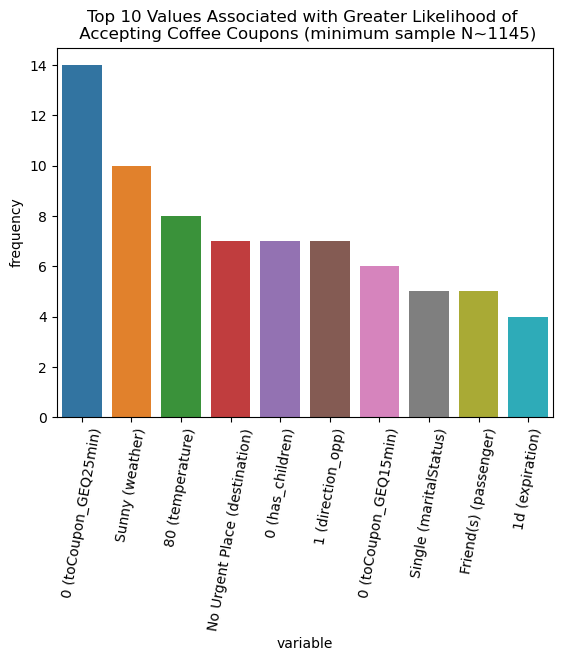

In [65]:
plot_title = 'Top 10 Values Associated with Greater Likelihood of \n Accepting Coffee Coupons (minimum sample N~1145)'
sns.barplot(pd.DataFrame(count_list_sorted_1145[:10], columns=['variable', 'frequency']), x='variable', y='frequency')
plt.title(plot_title)
plt.xticks(rotation=80)
plt.show()

Here we see the most prevalent variable value was having the coupon location within 25 minutes, followed by sunny weather, temperature in the 80s, and a three-way tie for 4th: not having children, no urgent destination, and perhaps counterintuitively (unless my interpretation of this variable is incorrect), the coupon location being in the opposite direction of the destination, which may only be applicable when destination is NOT "No Urgent Place" (something to check for later)

Among the top ten values at least, there was no competition between variables of the same type, which I thought was interesting as may suggest particular variables to explore in more depth. 

We can have more confidence in this list because the sample size is high even if the acceptance rates have a lower ceiling.

Looking at the variable combinations with much smaller group sizes (n=30):

In [66]:
var_cols_list_30 = np.concatenate(coffee_var_rates_30.query('acceptance_rate > 0.5000')[['var_1', 'var_2']].values).ravel().tolist()
total_vars_30 = len(var_cols_list_30)
count_dict_30 = {key:0 for key in set(var_cols_list_30)}
for val in var_cols_list_30:
    count_dict_30[val] += 1
count_list_sorted_30 = sorted(count_dict_30.items(), key=lambda x:x[1], reverse=True)
count_list_sorted_30.remove(('0 (direction_opp)', 39))
for i in count_list_sorted_30[:20]:
    print(i)

('1d (expiration)', 56)
('1~3 (CoffeeHouse)', 56)
('4~8 (CoffeeHouse)', 52)
('0 (toCoupon_GEQ15min)', 50)
('10 (time_numeric)', 49)
('No Urgent Place (destination)', 49)
('80 (temperature)', 48)
('Friend(s) (passenger)', 47)
('gt8 (CoffeeHouse)', 41)
('37500 (income_min_numeric)', 39)
('1 (direction_same)', 39)
('12500 (income_min_numeric)', 39)
('0 (toCoupon_GEQ25min)', 38)
('14 (time_numeric)', 37)
('Partner (passenger)', 36)
('Single (maritalStatus)', 33)
('Some college - no degree (education)', 33)
('Sunny (weather)', 32)
('Male (gender)', 32)
('6250 (income_min_numeric)', 30)


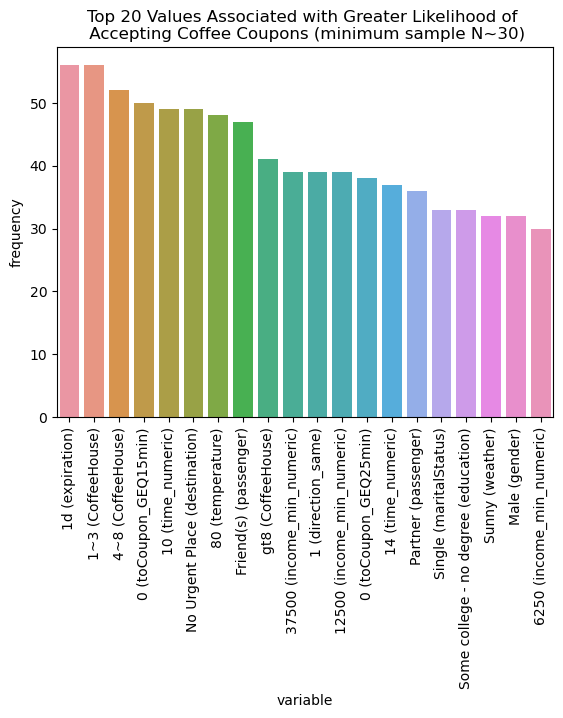

In [67]:
plot_title = 'Top 20 Values Associated with Greater Likelihood of \n Accepting Coffee Coupons (minimum sample N~30)'
sns.barplot(pd.DataFrame(count_list_sorted_30[:20], columns=['variable', 'frequency']), x='variable', y='frequency')
plt.title(plot_title)
plt.xticks(rotation=90)
plt.show()

With the smaller minimum sample sizes, we have more variable values associated with a greater than 50% likelihood of accepting the coupon. The top 5 values are expiration of 1 day, coffee place frequency between 1-8 times per month, being within 15 minutes of the coupon location, time of day being 10 am, and no urgent destination. Others in the top 10 that are also in the other list include temperature in the 80s and friends as passengers. It is interesting that the value tied to the most frequent coffee place attendance (greater than 8 times per month) appears fewer times than the values associated with less frequent (but still not never) attendance.

Further exploration on this path may consider looking at every available variable and seeing which value of each has the greatest frequency, such as above where 10 am occurs more than any other time of the day. 

Part of the reasoning of this approach besides convenience was that groups that are comprised of 3 or more variables would have increasingly smaller representative samples; however, future explorations may consider looking at groups comprised of more than 2 variables at once.

## Visualizing Acceptance Rates between Expiration and other Variables of Note

Based on our findings up till now, expiration was one variable that seemed to show noticeable differences of acceptance rates based on the value. We will explore a sample of combinations of the expiration and other variables:
- coffee place frequency
- passenger
- temperature

In [68]:
def setup_comparison_data(df, var_1, var_2, threshold=30, sort=True, sort_by = "acceptance_rate", ascending=False):
    
    data = df.groupby([var_1,var_2])['Y'].value_counts().unstack().reset_index()
#    For (rare) instances where a group has 100 % acceptance/refusal     
    data = data.fillna(0)
    data['total_count'] = data[1] + data[0]
    data['acceptance_rate'] = data[1] / data['total_count']
    data = data[[var_1,var_2, 'acceptance_rate', 'total_count']]
    if sort:
        assert sort_by in (var_1, var_2, "acceptance_rate", "total_count"), "cannot sort by chosen column"
        data = data.sort_values(sort_by, ascending=ascending).reset_index(drop=True)
    return data.query('total_count >= @threshold')

def plot_bar_comparison(sorted_data, var_1, var_2, plot_title, legend_title=None, rotation=75, errorbar=None):
    sns.barplot(sorted_data, x=var_1, y='acceptance_rate', hue=var_2, errorbar=errorbar)
    if legend_title is None:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=var_2)
    else:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=legend_title)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.ylim(0,1.0)
    plt.show()

def setup_and_barplot(df, var_1, var_2, plot_title, legend_title=None, rotation=75,  threshold=30, sort=True, sort_by="acceptance_rate", ascending=False, errorbar=None):
    sorted_data = setup_comparison_data(df, var_1, var_2, threshold=threshold, sort=sort, sort_by = sort_by, ascending=ascending)
    plot_bar_comparison(sorted_data, var_1, var_2, plot_title, legend_title=legend_title, rotation=rotation, errorbar=errorbar)

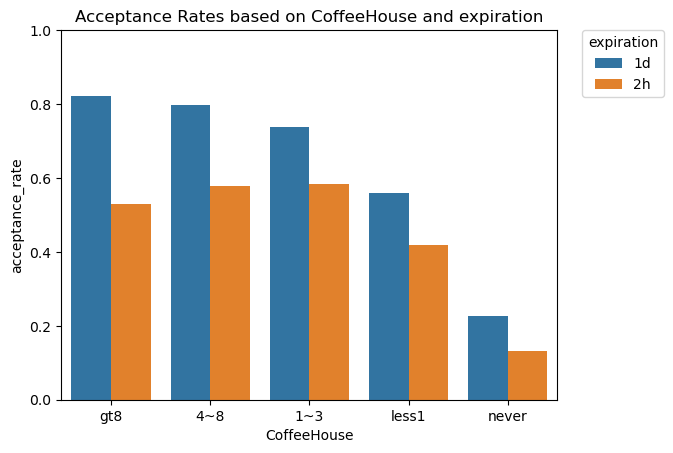

In [69]:
var_1 = 'CoffeeHouse'
var_2 = 'expiration'
title = "Acceptance Rates based on {var_1} and {var_2}".format(var_1=var_1,var_2=var_2)
args = (coffee_coupons, var_1, var_2, title)
kwargs = {"legend_title":None, "rotation":0, "threshold":30, "sort":True, "sort_by":"acceptance_rate",
         "ascending":False, "errorbar":None}
setup_and_barplot(*args, **kwargs)

Here we see acceptance rates declined monotonically with frequency among 1-day expirations, but there was not much change between those who went to coffee places at least once per month. There was a slight uptick in acceptance rates for 2-hour expirations for those who went to coffee places at least once a month but less frequently than the others. 1-day expiration coupons were uniformally more likely to be accepted regardless of frequency. 

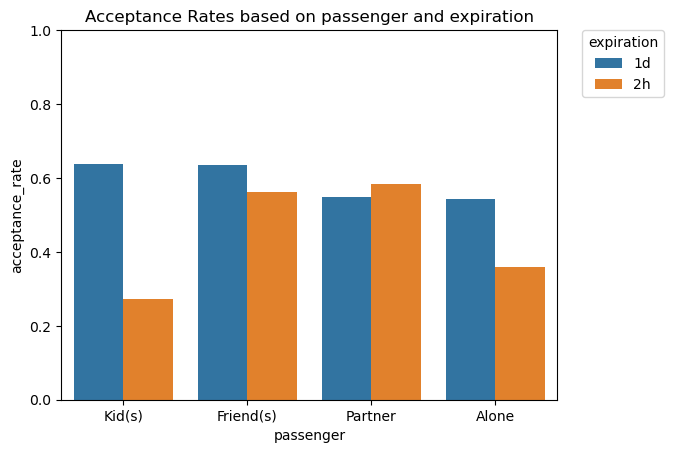

In [70]:
var_1 = 'passenger'
var_2 = 'expiration'
title = "Acceptance Rates based on {var_1} and {var_2}".format(var_1=var_1,var_2=var_2)
args = (coffee_coupons, var_1, var_2, title)
kwargs = {"legend_title":None, "rotation":0, "threshold":30, "sort":True, "sort_by":"acceptance_rate",
         "ascending":False, "errorbar":None}
setup_and_barplot(*args, **kwargs)

Here we see that with kids and being alone, there is a dramatic decrease in acceptance rate for the 2-hour coupon expiration. This also shows one of the rare instances where the 2-hour coupon (slightly) exceeds the 1-day coupon when the passenger is a partner. This is an example of how acceptance rates can vary dramatically both between groups and within groups depending on the combination of variable values.    

In [71]:
exp_vars = ["2h (expiration)", "1d (expiration)"]
pass_vars = ["Kid(s) (passenger)", "Friend(s) (passenger)", "Partner (passenger)", "Alone (passenger)"]
exp_n30 = coffee_var_rates_30.query('var_1 in @exp_vars or var_2 in @exp_vars').query("var_1 in @pass_vars or var_2 in @pass_vars")
exp_n30.reset_index(drop=True)

Y,var_1,var_2,acceptance_rate,total_count
0,Kid(s) (passenger),1d (expiration),0.638095,105.0
1,Friend(s) (passenger),1d (expiration),0.635398,565.0
2,Partner (passenger),2h (expiration),0.583893,149.0
3,Friend(s) (passenger),2h (expiration),0.562295,610.0
4,Partner (passenger),1d (expiration),0.549296,142.0
5,Alone (passenger),1d (expiration),0.543700,881.0
6,Alone (passenger),2h (expiration),0.358150,1276.0
7,Kid(s) (passenger),2h (expiration),0.272727,88.0


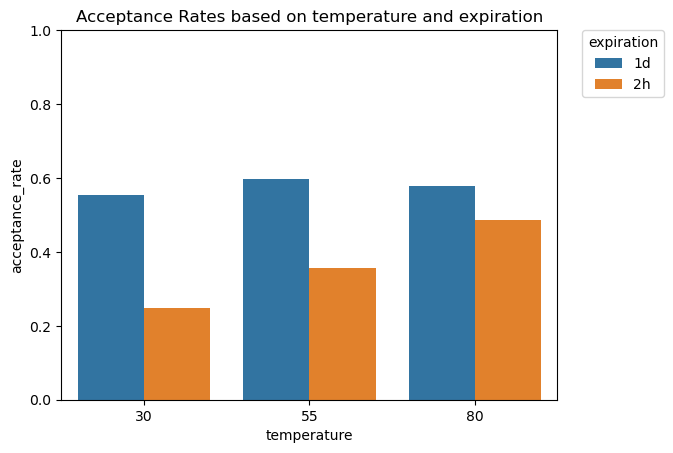

In [72]:
var_1 = 'temperature'
var_2 = 'expiration'
title = "Acceptance Rates based on {var_1} and {var_2}".format(var_1=var_1,var_2=var_2)
args = (coffee_coupons, var_1, var_2, title)
kwargs = {"legend_title":None, "rotation":0, "threshold":30, "sort":True, "sort_by":"acceptance_rate",
         "ascending":False, "errorbar":None}
setup_and_barplot(*args, **kwargs)

Here we see an intuitive case where temperature does not really seem correlated with acceptance rates for 1-day expiration coupons,  but it is for the 2-hour coupons, where acceptance rates increase with temperature. 

## Conclusion and Findings

This project looked at few approaches of determining what properties correlated with a higher coupon acceptance rate. We looked at coffee coupons in particular because they were the largest share of coupons but one of the lower rates.

After splitting the data into groups based on two variables, we counted the number of times certain values occured for groups with greater than 50% acceptance rate. Some of the standout properties include:

- **longer coupon expiration windows**
- **closer proximity to the coupon location upon delivery**
- **having no urgent destination**
- **good/warmer weather**
- **time of 10 am or 2 pm**
- **being with friends or partners**
- **mid to high coffee place frequency**
- **single**
- __income lower than $50k__

I would thus recommend delivering coffee coupons to those who fit these criteria

## Next Steps and Recommendations

- We can go further to find precise correlations between groups and coupon acceptance
- Odds ratios can tell us the relative odds for binary variables 
(i.e., "The odds of accepting the coupon doubles if a recipient is within 25 minutes of the coupon location")
- We can try to find the value(s) of each variable that most increase/decrease the likelihood of the coupon being accepted
- Further exploration of variables that have many values such as occupation and income
- Adding error bars to the acceptance rate bar plots as a reflection of group size
- Adding a 50% acceptance rate horizontal line on barplots for comparison